# Project3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy
import nltk

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
from sklearn import preprocessing
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('opinion_lexicon')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading p

In [5]:
try:
  import transformers
except:
  !pip install transformers
  import transformers

In [6]:
try:
  import textacy
except:
  !pip install textacy
  import textacy

Base directory.

In [7]:
BASE_DIR = '/content/drive/MyDrive/NLP_Final_Project3'
os.chdir(BASE_DIR)

Bring dataset.

In [8]:
file = "./reviews_5_balanced.json.gz"
raw_df = pd.read_json(file, lines=True)
raw_df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
0,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800
1,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800


In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294240 entries, 0 to 294239
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         294240 non-null  int64 
 1   verified        294240 non-null  bool  
 2   reviewTime      294240 non-null  object
 3   reviewerID      294240 non-null  object
 4   asin            294240 non-null  object
 5   reviewText      294240 non-null  object
 6   summary         294132 non-null  object
 7   unixReviewTime  294240 non-null  int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 16.0+ MB


In [10]:
raw_df.nunique()

,0
overall,4
verified,2
reviewTime,3071
reviewerID,181337
asin,126323
reviewText,222745
summary,84650
unixReviewTime,3071


In [11]:
raw_df['overall'].value_counts().sort_index()

,count
overall,
1,84851
2,59389
4,22860
5,127140


In [12]:
df = raw_df.copy()

In [13]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
0,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800
1,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800
2,1,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR5G,"Was terribly disappointed, the pants were way too large in the legs, my husband looked like he was wearing blown up clown pants.","Was terribly disappointed, the pants were way too large in ...",1486512000


In [14]:
df = df.drop(columns=['reviewTime','unixReviewTime'])
df = df.rename(columns={'reviewText': 'text'})
df.sample(5, random_state=12)

,overall,verified,reviewerID,asin,text,summary
163807,5,False,A2A8GHFXUG1B28,B0045Z4JAI,Good Decaf... it has a good flavour for a decaf :),Nice!
195640,5,True,A1VU337W6PKAR3,B00K0TIC56,"I could not ask for a better system for my small greenhouse, easy to set up and nozzles do very well",I could not ask for a better system for my small greenhouse
167820,4,True,A1Z5TT1BBSDLRM,B0012ORBT6,good product at a good price and saves a trip to the store,Four Stars
104268,1,False,A4PRXX2G8900X,B005SPI45U,I like the principle of a raw chip - something I can eat with my homemade salsa and guac - but these taste absolutely revolting.,No better alternatives but still tastes bad.
51961,1,True,AYETYLNYDIS2S,B00D1HLUP8,"Fake China knockoff, you get what you pay for.",Definitely not OEM


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294240 entries, 0 to 294239
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     294240 non-null  int64 
 1   verified    294240 non-null  bool  
 2   reviewerID  294240 non-null  object
 3   asin        294240 non-null  object
 4   text        294240 non-null  object
 5   summary     294132 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 11.5+ MB


----

## Bing Liu Lexicon (Baseline model)

In [16]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words in opinion lexicon',
      opinion_lexicon.positive()[:5])
print('Examples of negative words in opinion lexicon',
      opinion_lexicon.negative()[:5])

Total number of words in opinion lexicon 6789
Examples of positive words in opinion lexicon ['a+', 'abound', 'abounds', 'abundance', 'abundant']
Examples of negative words in opinion lexicon ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


In [17]:
# Let's create a dictionary which we can use for scoring our review text

pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
        word_dict[word] = pos_score

# Adding the negative words to the dictionary
for word in opinion_lexicon.negative():
        word_dict[word] = neg_score

def bing_liu_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

In [18]:
%%time
df['Bing_Liu_Score'] = df['text'].apply(bing_liu_score)
df[['asin','text','Bing_Liu_Score']].sample(2, random_state=0)

CPU times: user 16.8 s, sys: 28.7 ms, total: 16.8 s
Wall time: 17 s


,asin,text,Bing_Liu_Score
188097,B00099QWOU,As expected,0.00
184654,B000RW1XO8,Works as designed...,0.25


In [19]:
df['Bing_Liu_Score'].describe()

,Bing_Liu_Score
count,294240.00
mean,0.13
std,0.31
min,-1.00
25%,0.00
50%,0.06
75%,0.25
max,1.00


In [20]:
## verification
df['Bing_Liu_Score'] = preprocessing.scale(df['Bing_Liu_Score'])
df.groupby('overall').agg({'Bing_Liu_Score':'mean'})

,Bing_Liu_Score
overall,
1,-0.59
2,-0.43
4,0.35
5,0.53


In [21]:
df['Bing_Liu_Score'].describe()

,Bing_Liu_Score
count,294240.00
mean,0.00
std,1.00
min,-3.66
25%,-0.43
50%,-0.24
75%,0.38
max,2.81


___


## Supervised Learning Approaches

### Prepare the dataset

In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = raw_df.copy()
df = df.rename(columns={'reviewText': 'text'})

# Assigning a new [1,0] target class label based on the product rating
df.loc[df['overall'] > 3, 'sentiment'] = 1
df.loc[df['overall'] < 3, 'sentiment'] = 0

# Removing unecessary columns to keep a simple dataframe
df.drop(columns=[
    'reviewTime', 'unixReviewTime', 'overall', 'reviewerID', 'summary'],
        inplace=True)
df.sample(3)

,verified,asin,text,sentiment
136272,True,B016YZFUIG,just barely work .. not very heavy duty,0.00
187482,True,B000P3ZNTK,good value for the money spent,1.00
138335,True,B000SKTHOC,i order Hirt's Gardens brand and received china unbrand that fraud things ever,0.00


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294240 entries, 0 to 294239
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   verified   294240 non-null  bool   
 1   asin       294240 non-null  object 
 2   text       294240 non-null  object 
 3   sentiment  294240 non-null  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 7.0+ MB


In [24]:
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
1.00,0.51
0.00,0.49


### Data preparation

In [25]:
import tqdm
import textacy
import spacy
from spacy.lang.en import STOP_WORDS as stop_words
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nlp = spacy.load("en_core_web_sm")

In [26]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) #look around the sequence of interest  "^" & "$" stands resp. for beginning and end of a line or string "?:" stands for "look around but don't capture"
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [27]:
df['text_orig'] = df['text'].copy()
df['text'] = df['text'].apply(clean)

In [28]:
# First method that performs Tokenization and Lemmatization by re-using the blueprint from Chapter 4
# This can take longer to run due to the size of the dataset!
import textacy
import spacy
from spacy.lang.en import STOP_WORDS as stop_words
nlp = spacy.load("en_core_web_sm")

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc,
                                                    filter_stops = False,
                                                    filter_punct = True,
                                                    filter_nums = True,
                                                    include_pos = ['ADJ', 'NOUN', 'VERB', 'ADV'],
                                                    exclude_pos = None,
                                                    min_freq = 1)]

def clean_text(text):
    doc = nlp(text)
    lemmas = extract_lemmas(doc)
    return ' '.join(lemmas)

In [29]:
# Alternate method that uses Wordnet POS tags instead of spaCy - can run faster with similar accuracy
# Tokenization and Lemmatization using wordnet. Re-uses parts of blueprint from Chapter 4
# Uses wordnet POS tags instead of spaCy
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')

def clean_text_(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_60, df_40 = train_test_split(df, test_size=0.4, stratify=df['sentiment'], random_state=42)

Because our dataset is too huge, here we take 40% of data to faster the process.

In [32]:
%%time

df_40["text"] = df_40["text"].apply(clean_text_)

## Remove observations that are empty after the cleaning step
df_40 = df_40[df_40['text'].str.len() != 0]

CPU times: user 46.5 s, sys: 1.84 s, total: 48.3 s
Wall time: 50.4 s


### Train-Test Split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_40['text'],
                                                    df_40['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_40['sentiment'])

print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', Y_train.value_counts(normalize=True)[1] * 100.0)
print ('Negative Sentiment ', Y_train.value_counts(normalize=True)[0] * 100.0)

print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', sum(Y_test == 1)/ len(Y_test) * 100.0)
print ('Negative Sentiment ', sum(Y_test == 0)/ len(Y_test) * 100.0)

Size of Training Data  93636
Size of Test Data  23410
Distribution of classes in Training Data :
Positive Sentiment  50.90670255030116
Negative Sentiment  49.09329744969884
Distribution of classes in Testing Data :
Positive Sentiment  50.905595899188384
Negative Sentiment  49.094404100811616


### Text Vectorization and Modeling

Here comes our topic, the affect of different vectorization methods. Here we'll explore many methods, in this case, we need fix our model.

#### Method3-TfidfVectorizer (start point)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [35]:
type(X_train_tf)

scipy.sparse._csr.csr_matrix

In [36]:
X_train_tf

<93636x3308 sparse matrix of type '<class 'numpy.float64'>'
	with 423826 stored elements in Compressed Sparse Row format>

#### Method3---Random Forest

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=42, n_jobs=-1)
model1.fit(X_train_tf, Y_train)

CPU times: user 2min 32s, sys: 314 ms, total: 2min 32s
Wall time: 1min 24s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report

Y_pred = model1.predict(X_test_tf)
Y_pred_proba = model1.predict_proba(X_test_tf)[:,1]
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_proba))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8599316531396839
ROC-AUC Score -  0.9332553511654075
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     11493
         1.0       0.87      0.85      0.86     11917

    accuracy                           0.86     23410
   macro avg       0.86      0.86      0.86     23410
weighted avg       0.86      0.86      0.86     23410



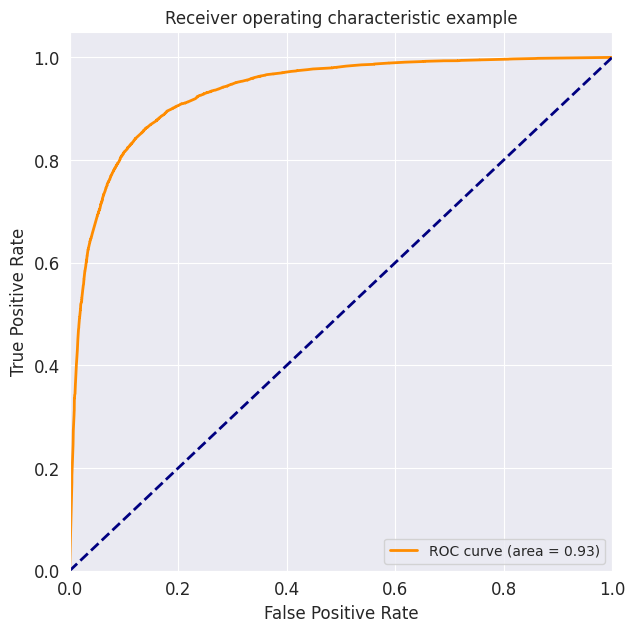

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


#### Method3-Prediction on some sample reviews

In [40]:
sample_reviews = df_60.sample(5, random_state=22)
sample_reviews_tf = tfidf.transform(sample_reviews['text'])
sentiment_predictions = model1.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['text_orig','sentiment_prediction']]

Some sample reviews with their sentiment - 


,text_orig,sentiment_prediction
149152,Great scent love them from this brand,1.00
280270,Works great for quick dusting.,1.00
271564,good quality product,1.00
254189,so nice I left them as is black did not paint them white as the original mirror\nsuperb quality,0.00
50159,Got it for my mom's phone she didn't like it said it made the phone very slipper and easy to drop.,0.00


#### Compare with the lexicon based scores

In [41]:
def baseline_scorer(text):
    score = bing_liu_score(text)
    if score > 0:
        return 1
    else:
        return 0

Y_pred_baseline = X_test.apply(baseline_scorer)
acc_score = accuracy_score(Y_test, Y_pred_baseline)
print (acc_score)

0.7568133276377617


#### Method3---XGBoost

In [42]:
from xgboost import XGBClassifier

model2 = XGBClassifier(random_state=42, n_jobs=-1)
model2.fit(X_train_tf, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [43]:
Y_pred = model2.predict(X_test_tf)
Y_pred_proba = model2.predict_proba(X_test_tf)[:,1]
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_proba))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8418624519436139
ROC-AUC Score -  0.9219669639803443
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85     11493
         1.0       0.89      0.79      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.85      0.84      0.84     23410
weighted avg       0.85      0.84      0.84     23410



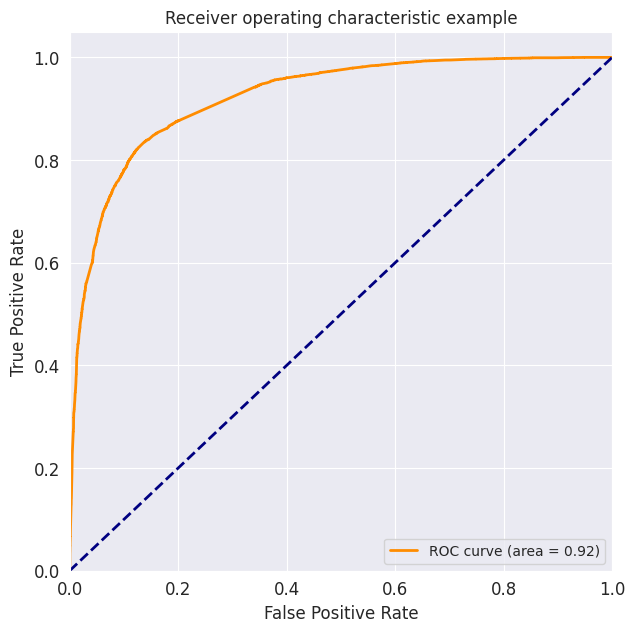

In [44]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Method3---LightGBM

In [45]:
from lightgbm import LGBMClassifier

model3 = LGBMClassifier(random_state=42, n_jobs=-1)
model3.fit(X_train_tf, Y_train)

[LightGBM] [Info] Number of positive: 47667, number of negative: 45969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.908435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96938
[LightGBM] [Info] Number of data points in the train set: 93636, number of used features: 2201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509067 -> initscore=0.036272
[LightGBM] [Info] Start training from score 0.036272


LGBMClassifier(n_jobs=-1, random_state=42)

In [46]:
Y_pred = model3.predict(X_test_tf)
Y_pred_proba = model3.predict_proba(X_test_tf)[:,1]
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_proba))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8489107219137121
ROC-AUC Score -  0.9266425865710962
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85     11493
         1.0       0.88      0.81      0.85     11917

    accuracy                           0.85     23410
   macro avg       0.85      0.85      0.85     23410
weighted avg       0.85      0.85      0.85     23410



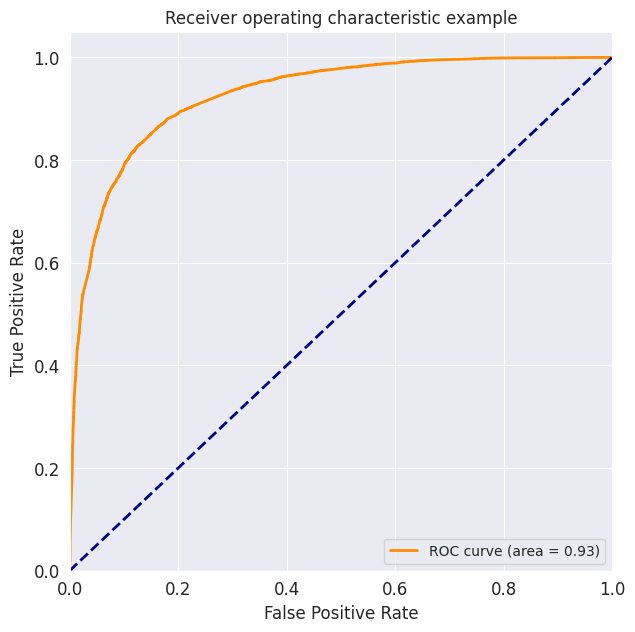

In [47]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Method3---Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

model4 = LogisticRegression(random_state=42, n_jobs=-1)
model4.fit(X_train_tf, Y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [49]:
Y_pred = model4.predict(X_test_tf)
Y_pred_proba = model4.predict_proba(X_test_tf)[:,1]
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_proba))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8656984194788552
ROC-AUC Score -  0.9369679079277423
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87     11493
         1.0       0.88      0.85      0.87     11917

    accuracy                           0.87     23410
   macro avg       0.87      0.87      0.87     23410
weighted avg       0.87      0.87      0.87     23410



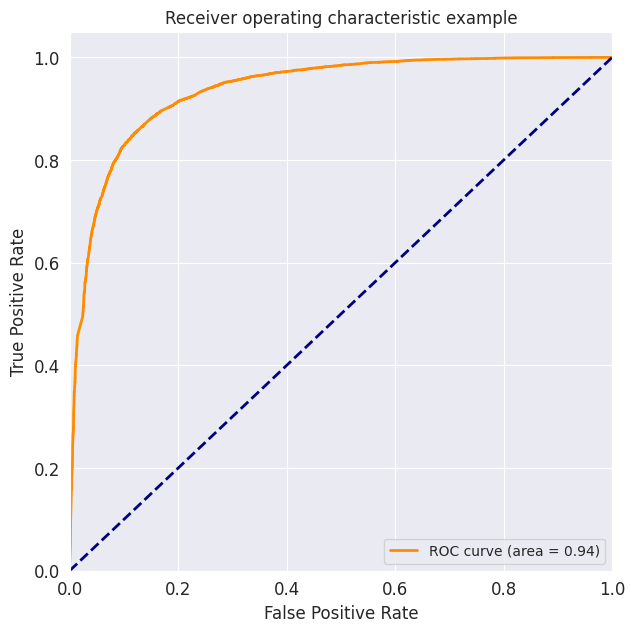

In [50]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Method3---Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB

model5 = MultinomialNB()
model5.fit(X_train_tf, Y_train)

MultinomialNB()

In [52]:
Y_pred = model5.predict(X_test_tf)
Y_pred_proba = model5.predict_proba(X_test_tf)[:,1]
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_proba))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8454506621102094
ROC-AUC Score -  0.9255283694178099
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84     11493
         1.0       0.85      0.84      0.85     11917

    accuracy                           0.85     23410
   macro avg       0.85      0.85      0.85     23410
weighted avg       0.85      0.85      0.85     23410



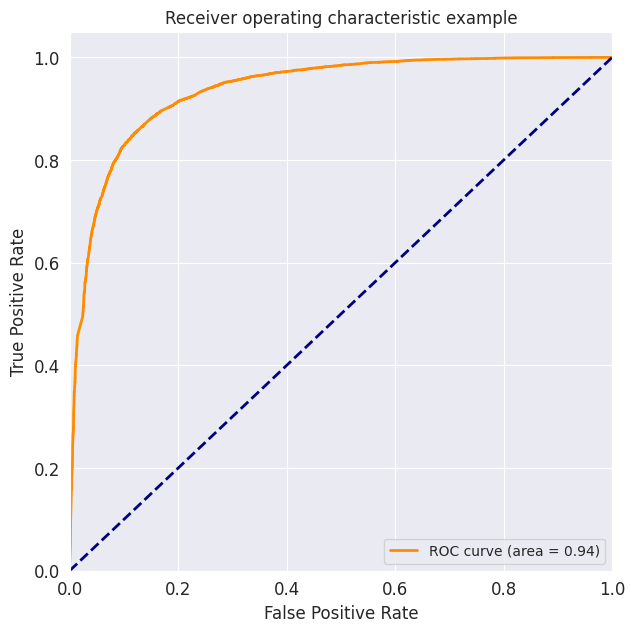

In [53]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Method3---SVC

In [54]:
from sklearn.svm import LinearSVC, SVC

model6 = LinearSVC(random_state=42)
model6.fit(X_train_tf, Y_train)

LinearSVC(random_state=42)

In [55]:
Y_pred = model6.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print (classification_report(Y_test, Y_pred))

Accuracy Score -  0.8609568560444255
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     11493
         1.0       0.87      0.85      0.86     11917

    accuracy                           0.86     23410
   macro avg       0.86      0.86      0.86     23410
weighted avg       0.86      0.86      0.86     23410



---

#### Method4---NMF

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [57]:
from sklearn.decomposition import NMF
n_topics = 100
nmf = NMF(n_components=n_topics, random_state=42)
X_train_nmf = nmf.fit_transform(X_train_tf)
X_test_nmf = nmf.transform(X_test_tf)


Model: Random Forest
Accuracy Score: 0.8454
ROC-AUC Score: 0.9212

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85     11493
         1.0       0.87      0.82      0.84     11917

    accuracy                           0.85     23410
   macro avg       0.85      0.85      0.85     23410
weighted avg       0.85      0.85      0.85     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.8475
ROC-AUC Score: 0.9276

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85     11493
         1.0       0.86      0.83      0.85     11917

    accuracy                           0.85     23410
   macro avg       0.85      0.85      0.85     23410
weighted avg       0.85      0.85      0.85     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

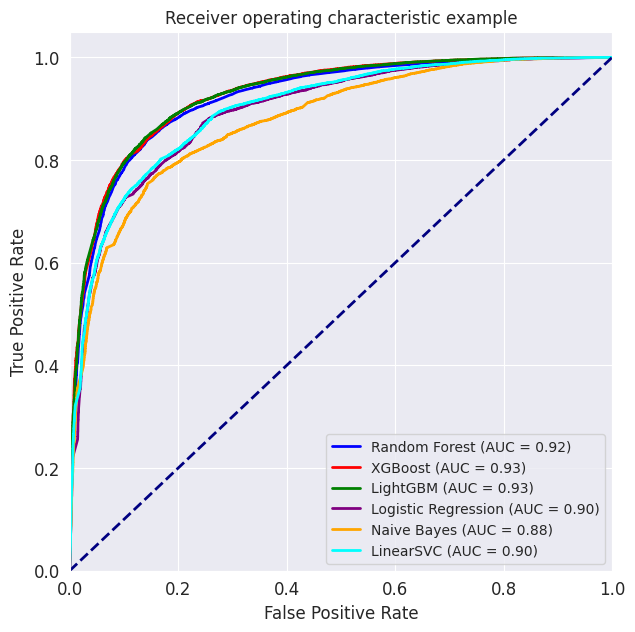

In [58]:
from sklearn.calibration import CalibratedClassifierCV

colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_nmf, Y_train)
    Y_pred = model.predict(X_test_nmf)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_nmf)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_nmf)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

#### Method5---LSA

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [60]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_tf)
X_test_svd = svd.transform(X_test_tf)


Model: Random Forest
Accuracy Score: 0.8413
ROC-AUC Score: 0.9173

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     11493
         1.0       0.86      0.82      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.84      0.84      0.84     23410
weighted avg       0.84      0.84      0.84     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.8407
ROC-AUC Score: 0.9208

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     11493
         1.0       0.85      0.83      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.84      0.84      0.84     23410
weighted avg       0.84      0.84      0.84     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

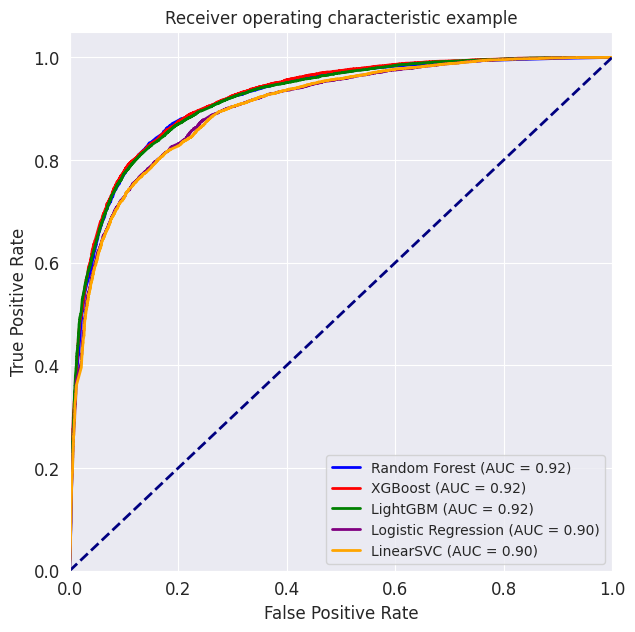

In [61]:
from sklearn.calibration import CalibratedClassifierCV

colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    # "Naive Bayes": MultinomialNB(),  # because we have negative values
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_svd, Y_train)
    Y_pred = model.predict(X_test_svd)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_svd)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_svd)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

#### Method6---LDA

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english',min_df=10)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 100
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_train_lda = lda.fit_transform(X_train_cv)
X_test_lda = lda.transform(X_test_cv)


Model: Random Forest
Accuracy Score: 0.7778
ROC-AUC Score: 0.8547

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78     11493
         1.0       0.80      0.75      0.77     11917

    accuracy                           0.78     23410
   macro avg       0.78      0.78      0.78     23410
weighted avg       0.78      0.78      0.78     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.7773
ROC-AUC Score: 0.8597

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78     11493
         1.0       0.81      0.74      0.77     11917

    accuracy                           0.78     23410
   macro avg       0.78      0.78      0.78     23410
weighted avg       0.78      0.78      0.78     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

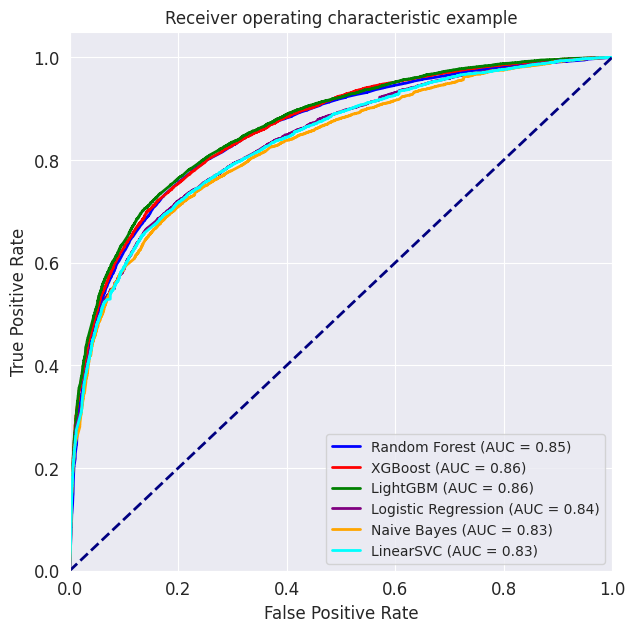

In [64]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_lda, Y_train)
    Y_pred = model.predict(X_test_lda)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_lda)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_lda)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

#### Method7---Word2Vec

##### Tokenization

In [65]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokenize(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
X_train_tokenized = [spacy_tokenize(doc) for doc in X_train]
X_test_tokenized = [spacy_tokenize(doc) for doc in X_test]

In [66]:
import gensim
from gensim.models import Word2Vec

# train word vectors
w2v = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1)

# document vectors, take the mean
def document_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)  # zero vectors for OOW
    return np.mean(model.wv[words], axis=0)

X_train_w2v = np.array([document_vector(doc, w2v) for doc in X_train_tokenized])
X_test_w2v = np.array([document_vector(doc, w2v) for doc in X_test_tokenized])


Model: Random Forest
Accuracy Score: 0.8430
ROC-AUC Score: 0.9214

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84     11493
         1.0       0.86      0.82      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.84      0.84      0.84     23410
weighted avg       0.84      0.84      0.84     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.8402
ROC-AUC Score: 0.9202

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     11493
         1.0       0.85      0.83      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.84      0.84      0.84     23410
weighted avg       0.84      0.84      0.84     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

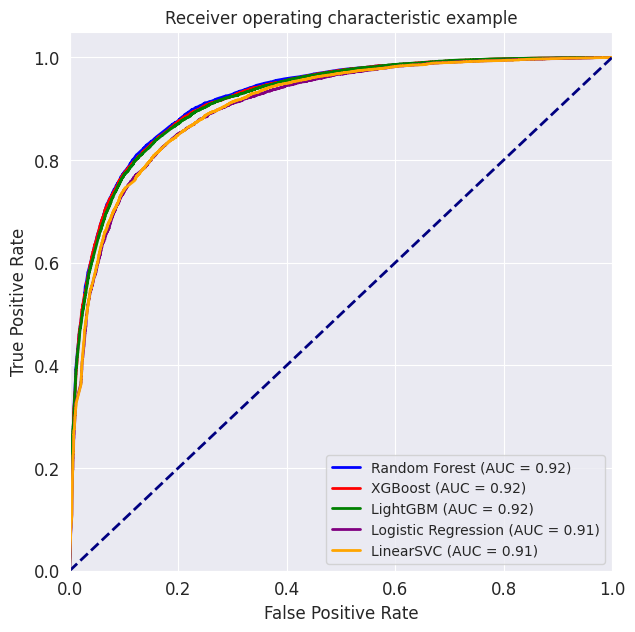

In [67]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    # "Naive Bayes": MultinomialNB(),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_w2v, Y_train)
    Y_pred = model.predict(X_test_w2v)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_w2v)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_w2v)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

#### Method8---Glove

In [68]:
# first load glove vectors
def load_glove_vectors(filepath, vector_size=100):
    glove_vectors = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]   # here we pick the word, the first element
            vector = np.array(values[1:], dtype="float32")  # word vectors
            glove_vectors[word] = vector # store as dictionary
    return glove_vectors

# compute doc vectors
def document_vector(doc, glove_vectors, vector_size=100):
    words = [word for word in doc if word in glove_vectors]
    if len(words) == 0:
        return np.zeros(vector_size)  # deal with unknown words
    return np.mean([glove_vectors[word] for word in words], axis=0) # take the mean


In [69]:
# load
glove_vectors = load_glove_vectors("./glove.6B.100d.txt")

Professor, you need have this file in your working directory.

In [70]:
X_train_glove = np.array([document_vector(doc, glove_vectors) for doc in X_train_tokenized])
X_test_glove = np.array([document_vector(doc, glove_vectors) for doc in X_test_tokenized])


Model: Random Forest
Accuracy Score: 0.8217
ROC-AUC Score: 0.9033

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.83     11493
         1.0       0.85      0.78      0.82     11917

    accuracy                           0.82     23410
   macro avg       0.82      0.82      0.82     23410
weighted avg       0.82      0.82      0.82     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.8284
ROC-AUC Score: 0.9108

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     11493
         1.0       0.84      0.82      0.83     11917

    accuracy                           0.83     23410
   macro avg       0.83      0.83      0.83     23410
weighted avg       0.83      0.83      0.83     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

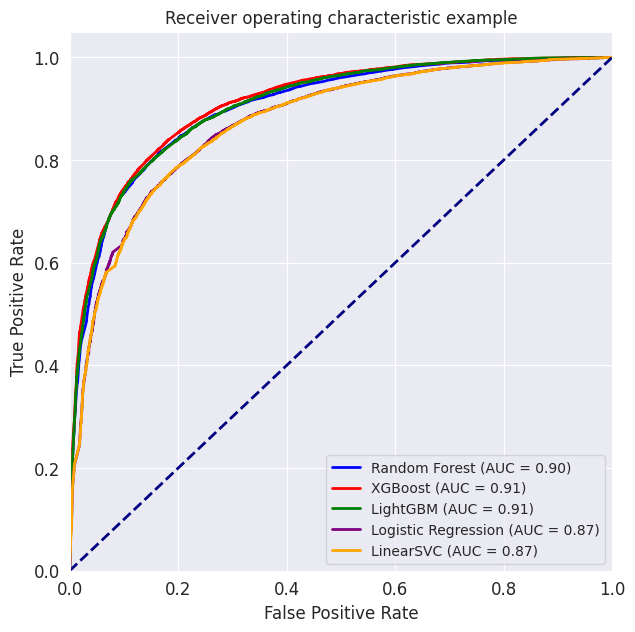

In [71]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    # "Naive Bayes": MultinomialNB(),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_glove, Y_train)
    Y_pred = model.predict(X_test_glove)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_glove)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_glove)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

#### Method9---FastText

In [72]:
from gensim.models import FastText

fasttext_model = FastText(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1)

def document_vector(doc, model):
    words = [word for word in doc if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X_train_fasttext = np.array([document_vector(doc, fasttext_model) for doc in X_train_tokenized])
X_test_fasttext = np.array([document_vector(doc, fasttext_model) for doc in X_test_tokenized])


Model: Random Forest
Accuracy Score: 0.8362
ROC-AUC Score: 0.9179

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84     11493
         1.0       0.86      0.82      0.84     11917

    accuracy                           0.84     23410
   macro avg       0.84      0.84      0.84     23410
weighted avg       0.84      0.84      0.84     23410

--------------------------------------------------

Model: XGBoost
Accuracy Score: 0.8335
ROC-AUC Score: 0.9153

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83     11493
         1.0       0.85      0.82      0.83     11917

    accuracy                           0.83     23410
   macro avg       0.83      0.83      0.83     23410
weighted avg       0.83      0.83      0.83     23410

--------------------------------------------------
[LightGBM] [Info] Number of positive: 47667, number of negative: 459

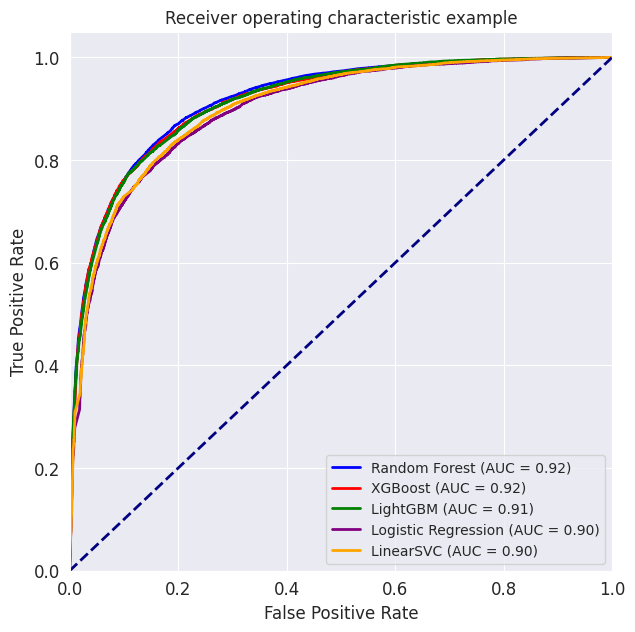

In [73]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    # "Naive Bayes": MultinomialNB(),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(random_state=42, dual=False), method='sigmoid')
}

results = []
plt.figure(figsize=(7, 7))

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_fasttext, Y_train)
    Y_pred = model.predict(X_test_fasttext)
    accuracy = accuracy_score(Y_test, Y_pred)

    # probability
    if hasattr(model, "predict_proba"):
        Y_pred_proba = model.predict_proba(X_test_fasttext)[:, 1]
    else:
        Y_pred_proba = model.decision_function(X_test_fasttext)  # for SVM

    # ROC-AUC
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results.append((name, accuracy, roc_auc))

    plt.plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # result
    print(f"\nModel: {name}")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

### Saving the trained model and vectorizer for use with the API later

To be continued with part2